In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming `data` is your original DataFrame
data = pd.read_csv(r"C:\Users\USER\Chameleon\MOP-Code\artificial-intelligence\Traffic Analysis\dataset\traffic_volume_analysis.csv")

data.head()

,road_name,location,suburb,speed_limit,average_speed,85th_percentile_speed,maximum_speed,road_segment,datetime,hour,...,year,road_name_encoded,location_encoded,suburb_encoded,Total_Traffic_Volume,month,month_name,day_type,Speeding_Incident,time_of_day
0,Wolseley Parade,North East Of Derby Street,Kensington,50,35.500000,40.400000,46.918791,21727,2014-10-11 16:00:00,16,...,2014,107,103,4,34.292179,10,October,Weekend,False,Afternoon
1,Wolseley Parade,North East Of Derby Street,Kensington,50,33.800000,40.700000,46.918791,21727,2014-10-11 17:00:00,17,...,2014,107,103,4,52.292179,10,October,Weekend,False,Afternoon
2,Wolseley Parade,North East Of Derby Street,Kensington,50,36.900000,42.900000,46.918791,21727,2014-10-11 18:00:00,18,...,2014,107,103,4,40.198183,10,October,Weekend,False,Evening
3,Wolseley Parade,North East Of Derby Street,Kensington,50,30.700000,33.700000,46.918791,21727,2014-11-11 02:00:00,2,...,2014,107,103,4,13.292179,11,November,Weekday,False,Night
4,Wolseley Parade,North East Of Derby Street,Kensington,50,32.298564,37.900167,46.918791,21727,2014-11-11 04:00:00,4,...,2014,107,103,4,96.469563,11,November,Weekday,False,Night


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
# Select relevant features
features = [
    'road_name_encoded', 'location_encoded', 'suburb_encoded', 
    'speed_limit', 'hour', 'day_of_week', 'month', 'average_speed'
]
target = 'Total_Traffic_Volume'

# Encode categorical variables
label_encoder = LabelEncoder()
data['day_type_encoded'] = label_encoder.fit_transform(data['day_type'])

# Prepare the final features list including encoded 'day_type'
final_features = features + ['day_type_encoded']

# Split data into training and testing sets
X = data[final_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # regression with RMSE as loss
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model with early stopping
xgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],  
    verbose=False
)
y_pred= xgb_model.predict(X_test)
# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Output the performance metrics
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R² Score: 0.9180870429631923
Mean Absolute Error (MAE): 24.959992448811075
Root Mean Squared Error (RMSE): 51.50272171223217


In [75]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use RMSE for scoring
    verbose=1,
    random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Get the best model from the search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Output the best parameters and RMSE from cross-validation
best_params = random_search.best_params_
best_cv_rmse = (-random_search.best_score_) ** 0.5  # Convert to RMSE

print("Best Parameters:", best_params)
print("Best Cross-validated RMSE:", best_cv_rmse)

# Output the performance metrics on the test set
print(f"R² Score on Test Set: {r2}")
print(f"Mean Absolute Error (MAE) on Test Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-validated RMSE: 47.421805515153395
R² Score on Test Set: 0.9275131671916351
Mean Absolute Error (MAE) on Test Set: 21.387414077030925
Root Mean Squared Error (RMSE) on Test Set: 48.4488463814894


In [80]:


# Example input for prediction (replace with your actual input data)
input_data = {
    'road_name_encoded': 107,
    'location_encoded': 103,
    'suburb_encoded': 4,
    'speed_limit': 50,
    'hour': 16,
    'day_of_week': 5,
    'month': 10,
    'average_speed': 35.5,
    'day_type_encoded': 1
}

# Convert the input data into a DataFrame for prediction
input_df = pd.DataFrame([input_data])

# Make prediction using the best XGBoost model from RandomizedSearchCV
predicted_traffic_volume = best_model.predict(input_df)

# Output the predicted traffic volume
print(f"Predicted Total Traffic Volume: {predicted_traffic_volume[0]}")


Predicted Total Traffic Volume: 36.756900787353516


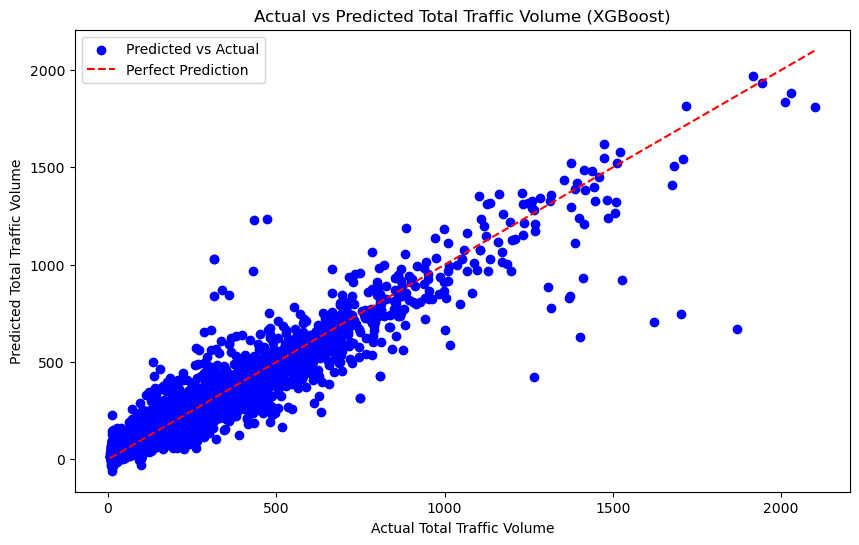

In [82]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values for the XGBoost model
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')

# Plot a line y=x for reference (perfect prediction line)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.xlabel("Actual Total Traffic Volume")
plt.ylabel("Predicted Total Traffic Volume")
plt.title("Actual vs Predicted Total Traffic Volume (XGBoost)")
plt.legend()

# Show the plot
plt.show()


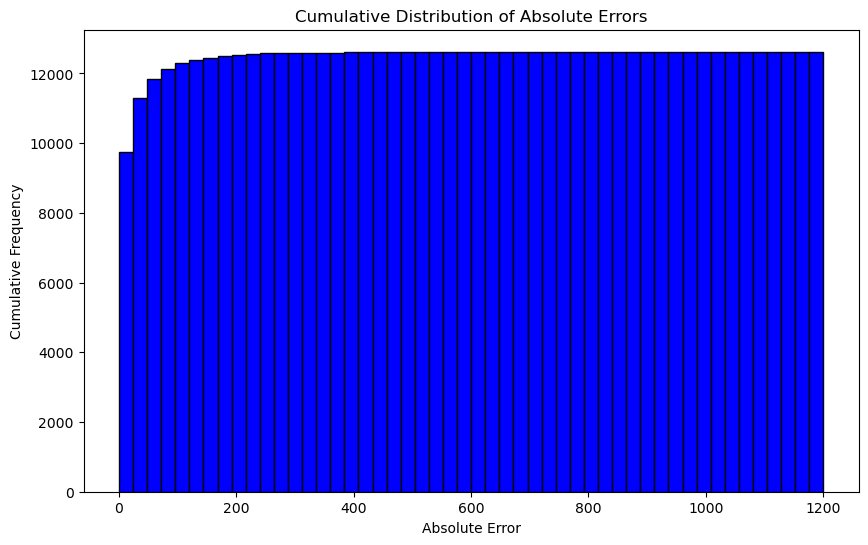

In [86]:
# Calculate absolute errors
absolute_errors = np.abs(y_test - y_pred)

# Plot cumulative distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(absolute_errors, bins=50, cumulative=True, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel("Absolute Error")
plt.ylabel("Cumulative Frequency")
plt.title("Cumulative Distribution of Absolute Errors")

# Show the plot
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_16828\2958787222.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=False, color="blue", label="Actual Traffic Volume")
C:\Users\USER\AppData\Local\Temp\ipykernel_16828\2958787222.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s

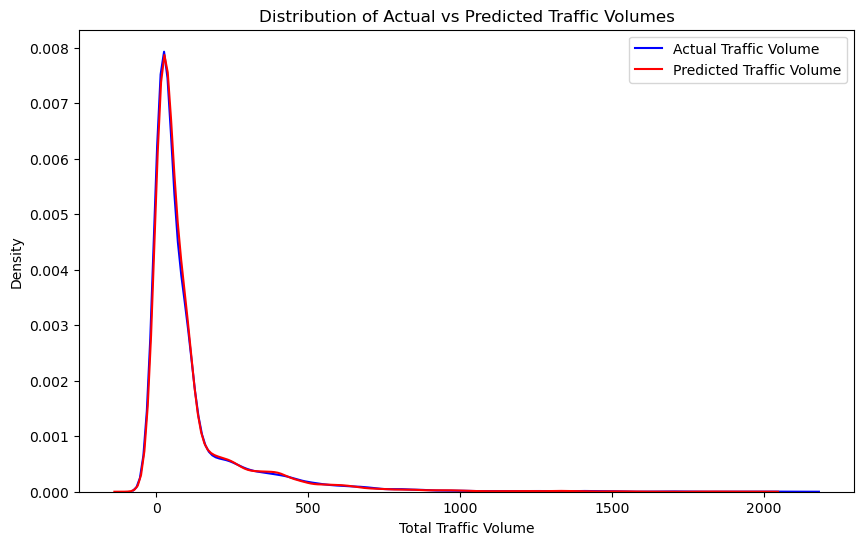

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the distribution of actual traffic volumes
sns.distplot(y_test, hist=False, color="blue", label="Actual Traffic Volume")

# Plot the distribution of predicted traffic volumes
sns.distplot(y_pred, hist=False, color="red", label="Predicted Traffic Volume")

# Add labels and title
plt.xlabel("Total Traffic Volume")
plt.ylabel("Density")
plt.title("Distribution of Actual vs Predicted Traffic Volumes")
plt.legend()

# Display the plot
plt.show()


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the parameter grid for LightGBM
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, -1],  # -1 indicates no limit
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(objective='regression', random_state=42)

# Set up the randomized search
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best parameters and score
best_params = random_search.best_params_
best_score = (-random_search.best_score_) ** 0.5  # Convert to RMSE

print("Best Parameters for LightGBM:", best_params)
print("Best Cross-validated RMSE for LightGBM:", best_score)

# Retrain the model with the best parameters
best_lgbm_model = LGBMRegressor(**best_params, objective='regression', random_state=42)
best_lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_best_lgbm = best_lgbm_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE (Root Mean Squared Error)
rmse_best_lgbm = mean_squared_error(y_test, y_pred_best_lgbm, squared=False)

# Calculate MAE (Mean Absolute Error)
mae_best_lgbm = mean_absolute_error(y_test, y_pred_best_lgbm)

# Calculate R-squared (R²)
r2_best_lgbm = r2_score(y_test, y_pred_best_lgbm)

# Print the evaluation metrics
print("Test Set RMSE with Best LightGBM Parameters:", rmse_best_lgbm)
print("Test Set MAE with Best LightGBM Parameters:", mae_best_lgbm)
print("Test Set R² with Best LightGBM Parameters:", r2_best_lgbm)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 40396, number of used features: 9
[LightGBM] [Info] Start training from score 111.209471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [20]:
# Print the evaluation metrics
print("Test Set RMSE with Best LightGBM Parameters:", rmse_best_lgbm)
print("Test Set MAE with Best LightGBM Parameters:", mae_best_lgbm)
print("Test Set R² with Best LightGBM Parameters:", r2_best_lgbm)


Test Set RMSE with Best LightGBM Parameters: 47.33999148659325
Test Set MAE with Best LightGBM Parameters: 22.320372594283707
Test Set R² with Best LightGBM Parameters: 0.9307932277779668


In [26]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }
    
    # Initialize the model with the trial parameters
    lgbm_model = LGBMRegressor(objective='regression', random_state=42, **params)
    
    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = (-cv_scores.mean()) ** 0.5
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# Print the best parameters and score
best_params = study.best_params
best_rmse = study.best_value

print("Best Parameters from Optuna:", best_params)
print("Best Cross-validated RMSE from Optuna:", best_rmse)

# Retrain the model with the best parameters
best_lgbm_model = LGBMRegressor(objective='regression', random_state=42, **best_params)
best_lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_best_lgbm = best_lgbm_model.predict(X_test)

# Calculate RMSE on the test set
rmse_best_lgbm = mean_squared_error(y_test, y_pred_best_lgbm, squared=False)

print("Test Set RMSE with Best LightGBM Parameters (Optuna):", rmse_best_lgbm)


[I 2024-09-04 07:04:53,652] A new study created in memory with name: no-name-1c61c8a5-87cc-4a7a-aae4-8fb583c6261a
C:\Users\USER\AppData\Local\Temp\ipykernel_24992\28225317.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\USER\AppData\Local\Temp\ipykernel_24992\28225317.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\USER\AppData\Local\Temp\ipykernel_24992\28225317.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use su

Best Parameters from Optuna: {'n_estimators': 898, 'learning_rate': 0.14043665592439272, 'max_depth': 16, 'min_child_weight': 7, 'subsample': 0.7521376386137146, 'colsample_bytree': 0.8722263965495575, 'reg_alpha': 0.0002122507368806005, 'reg_lambda': 0.010888629517403882}
Best Cross-validated RMSE from Optuna: 47.19031317102747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 50496, number of used features: 9
[LightGBM] [Info] Start training from score 111.831424
Test Set RMSE with Best LightGBM Parameters (Optuna): 47.68382454629035


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Predict the outcomes
y_pred = best_lgbm_model.predict(X_test)

# Print or save the predictions
print("Predicted Outcomes:", y_pred)

# Optionally, save the predictions to a CSV file for further analysis
pd.DataFrame(y_pred, columns=['Predicted_Value']).to_csv('predictions.csv', index=False)

Predicted Outcomes: [ 26.51083486 354.03850749 739.76497704 ... 101.04081236 103.01223684
  85.38239706]


In [24]:
import numpy as np

# Example: Manually entering a new input row with the features used for training
new_input = {
'road_name_encoded': 107,
    'location_encoded': 103,
    'suburb_encoded': 4,
    'speed_limit': 50,
    'hour': 16,
    'day_of_week': 5,
    'month': 10,
    'average_speed': 35.5,
    'day_type_encoded': 1     # Encoded value for day type (e.g., 0 = weekday, 1 = weekend)
}

# Convert the dictionary into a format the model can accept (a 2D array or DataFrame)
X_new = np.array([[new_input[feature] for feature in final_features]])

# Predict the total traffic volume using the trained model
predicted_volume = best_lgbm_model.predict(X_new)

print("Predicted Total Traffic Volume:", predicted_volume[0])


Predicted Total Traffic Volume: 37.75918956475421


In [28]:
import pandas as pd

# Assuming 'data' is your original DataFrame that contains the actual traffic volume and features

# Example input features (same as the ones you used for prediction)
new_input = {
    'road_name_encoded': 107,
    'location_encoded': 103,
    'suburb_encoded': 4,
    'speed_limit': 50,
    'hour': 16,
    'day_of_week': 5,
    'month': 10,
    'average_speed': 35.5,
    'day_type_encoded': 1
}

# Filter the dataset to find the row that matches the input features
actual_row = data[
    (data['road_name_encoded'] == new_input['road_name_encoded']) &
    (data['location_encoded'] == new_input['location_encoded']) &
    (data['suburb_encoded'] == new_input['suburb_encoded']) &
    (data['speed_limit'] == new_input['speed_limit']) &
    (data['hour'] == new_input['hour']) &
    (data['day_of_week'] == new_input['day_of_week']) &
    (data['month'] == new_input['month']) &
    (data['average_speed'] == new_input['average_speed']) &
    (data['day_type_encoded'] == new_input['day_type_encoded'])
]

# If the row exists, print the actual traffic volume
if not actual_row.empty:
    actual_traffic_volume = actual_row['Total_Traffic_Volume'].values[0]
    print("Actual Traffic Volume:", actual_traffic_volume)
else:
    print("No matching data found in the dataset.")


Actual Traffic Volume: 34.29217885759312


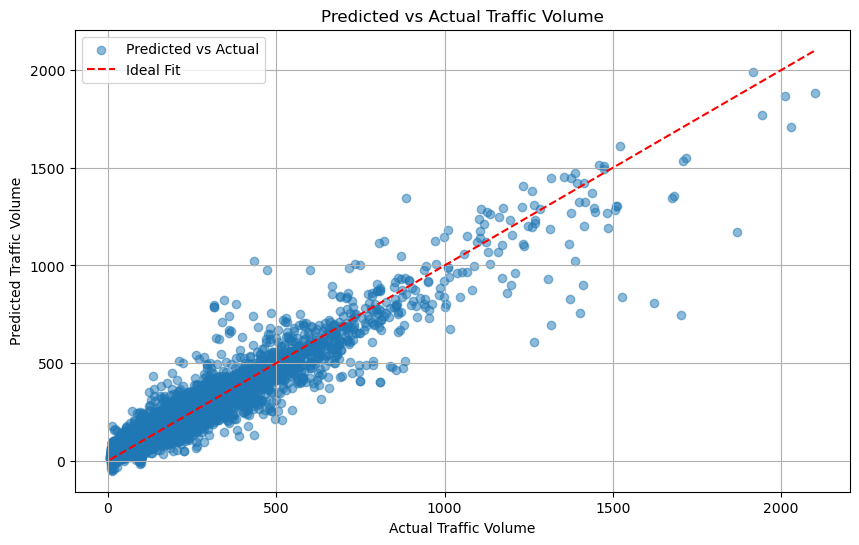

In [30]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual traffic volumes from the test set
# And y_pred_best_lgbm contains the predicted traffic volumes from the model

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_lgbm, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.title('Predicted vs Actual Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


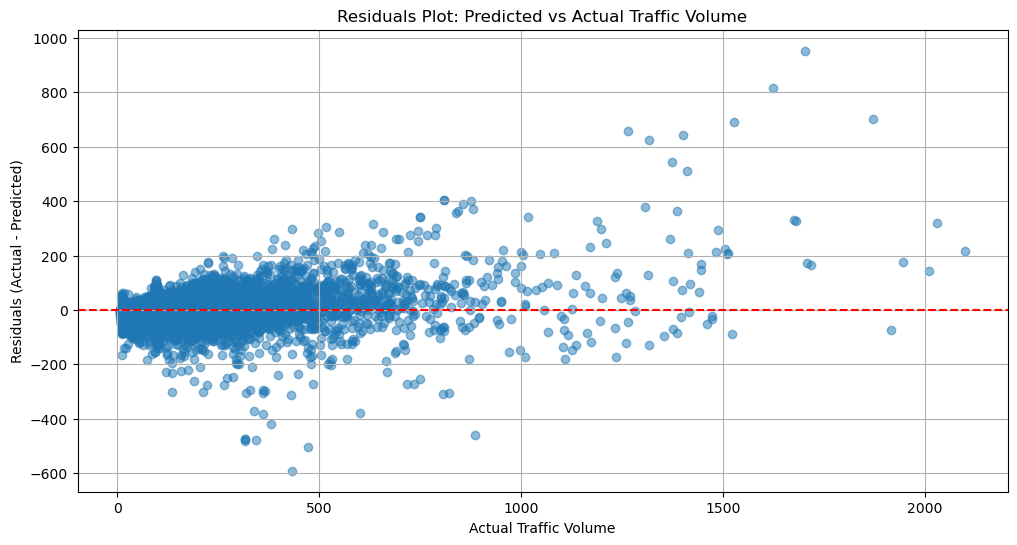

In [50]:
# Calculate residuals
residuals = y_test - y_pred_best_lgbm

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot: Predicted vs Actual Traffic Volume')
plt.grid(True)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_16828\2502646686.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual', color='blue', shade=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_16828\2502646686.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_best_lgbm, label='Predicted', color='orange', shade=True)


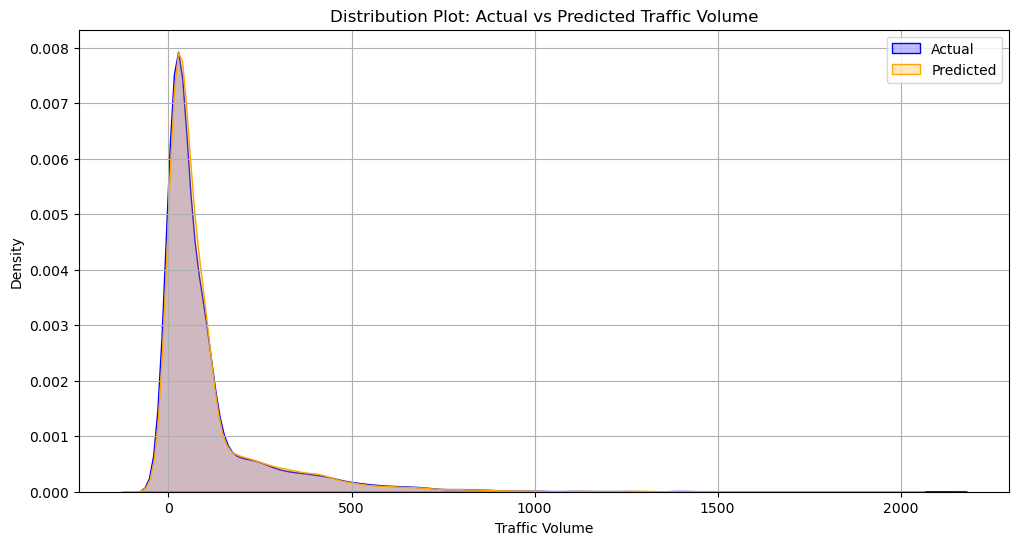

In [62]:
plt.figure(figsize=(12, 6))

# Plot the distributions of actual and predicted values
sns.kdeplot(y_test, label='Actual', color='blue', shade=True)
sns.kdeplot(y_pred_best_lgbm, label='Predicted', color='orange', shade=True)

# Add labels and title
plt.xlabel('Traffic Volume')
plt.title('Distribution Plot: Actual vs Predicted Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()
